# Phase 3: Complete EDA Analysis for Weather Prediction Model

This notebook combines key analyses from all five sub-phase notebooks (3A through 3E) into a comprehensive exploratory data analysis for our weather prediction model.

## Objectives:
1. Provide a complete statistical summary of the weather sensor data
2. Analyze distributions and relationships between all weather parameters
3. Identify weather patterns through clustering techniques
4. Assess data quality and prepare for model development
5. Deliver actionable insights for the weather prediction model

## Dataset Summary:
- **Records**: 693,220 environmental measurements
- **Parameters**: Temperature, Humidity, Pressure, Illuminance
- **Hardware**: ESP32-S3 with BME280, AHT10, and BH1750 sensors

---

## Section 1: Import Required Libraries

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import json
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis and machine learning
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configure display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print(f"📊 Complete EDA Analysis Notebook initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✓ All analysis libraries imported successfully")

📊 Complete EDA Analysis Notebook initialized at: 2025-09-15 15:57:25
✓ All analysis libraries imported successfully


## Section 2: Load and Prepare Datasets

In [2]:
# Set project paths
PROJECT_ROOT = Path(r"G:\\CSE Weather Model")
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

print("📥 Loading Primary Environmental Dataset (OPTIMIZED)...")
print("=" * 50)

# Load primary dataset with optimized parameters
primary_data_path = RAW_DATA_DIR / "primary_environmental" / "DATA-large.CSV"

# Check file size first
file_size_mb = primary_data_path.stat().st_size / (1024**2)
print(f"📁 File size: {file_size_mb:.1f} MB")

# Load with optimized data types for faster processing
print(f"🔧 Loading with optimized data types...")
dtype_map = {
    'temperature': 'float32',  # Reduce precision for speed
    'humidity': 'float32',
    'pressure': 'float32',
    'lux': 'float32'
}

# Load dataset efficiently
start_time = datetime.now()
df_primary = pd.read_csv(primary_data_path, dtype=dtype_map, low_memory=False)
load_time = (datetime.now() - start_time).total_seconds()

# Fast basic info (without deep memory analysis)
print(f"✅ Primary dataset loaded in {load_time:.2f}s:")
print(f"   📊 Shape: {df_primary.shape}")
print(f"   📋 Columns: {list(df_primary.columns)}")
print(f"   📈 Total records: {len(df_primary):,}")

# Quick sample without heavy formatting
print(f"\n🔍 Dataset Sample (first 3 rows):")
sample_data = df_primary.head(3)
print(sample_data)

# Fast data type check
print(f"\n📊 Dataset Information (Fast):")
print(f"   • Data types: {dict(df_primary.dtypes)}")
print(f"   • Memory usage (estimated): {df_primary.memory_usage(deep=False).sum() / 1024**2:.1f} MB")
print(f"   • Non-null counts: {dict(df_primary.count())}")

📥 Loading Primary Environmental Dataset (OPTIMIZED)...
📁 File size: 30.1 MB
🔧 Loading with optimized data types...
✅ Primary dataset loaded in 1.26s:
   📊 Shape: (693220, 5)
   📋 Columns: ['time', 'temperature', 'humidity', 'pressure', 'lux']
   📈 Total records: 693,220

🔍 Dataset Sample (first 3 rows):
                 time  temperature  humidity  pressure    lux
0   2022/3/12 22:32:2       24.200    32.700 98490.453 10.000
1   2022/3/12 22:32:6       24.000    33.900 98486.977 12.080
2  2022/3/12 22:32:11       24.100    33.900 98488.273 22.920

📊 Dataset Information (Fast):
   • Data types: {'time': dtype('O'), 'temperature': dtype('float32'), 'humidity': dtype('float32'), 'pressure': dtype('float32'), 'lux': dtype('float32')}
   • Memory usage (estimated): 15.9 MB
   • Non-null counts: {'time': np.int64(693220), 'temperature': np.int64(693220), 'humidity': np.int64(693220), 'pressure': np.int64(693220), 'lux': np.int64(693220)}
✅ Primary dataset loaded in 1.26s:
   📊 Shape: (693220

## Section 3: Basic Statistics & Pressure Conversion

This section imports pressure conversion functions from Phase 3A and applies them to the dataset.

In [3]:
# Apply pressure conversion (Pa to hPa) - critical fix from Phase 3A
print(f"🔧 Applying pressure unit conversion (Pa → hPa)...")

def convert_pressure_units(df, column='pressure', from_unit='Pa', to_unit='hPa'):
    """Convert pressure between different units.
    
    Supports: Pa, hPa, mbar, bar, atm, mmHg, inHg
    
    Args:
        df: DataFrame containing pressure data
        column: Name of pressure column
        from_unit: Original pressure unit
        to_unit: Target pressure unit
    
    Returns:
        DataFrame with converted pressure values
    """
    # Define conversion factors to Pa
    to_pascal = {
        'Pa': 1.0,
        'hPa': 100.0,
        'mbar': 100.0,  # 1 mbar = 100 Pa
        'bar': 100000.0,  # 1 bar = 100,000 Pa
        'atm': 101325.0,  # 1 atm = 101,325 Pa
        'mmHg': 133.322,  # 1 mmHg = 133.322 Pa
        'inHg': 3386.39  # 1 inHg = 3,386.39 Pa
    }
    
    # Make a copy of the dataframe to avoid modifying the original
    df_converted = df.copy()
    
    # Convert from source unit to Pascal first
    if from_unit not in to_pascal:
        raise ValueError(f"Unsupported source unit: {from_unit}")
    
    if to_unit not in to_pascal:
        raise ValueError(f"Unsupported target unit: {to_unit}")
    
    # Convert: source → Pa → target
    df_converted[column] = df_converted[column] * to_pascal[from_unit] / to_pascal[to_unit]
    
    return df_converted

# Apply the conversion function to our dataset
df_primary = convert_pressure_units(df_primary, column='pressure', from_unit='Pa', to_unit='hPa')
print(f"✅ Pressure values converted from Pa to hPa")

# Calculate and display basic statistics
print(f"\n📊 Basic Statistical Summary of Sensor Data")
print("=" * 50)
sensor_stats = df_primary[['temperature', 'humidity', 'pressure', 'lux']].describe()
print(sensor_stats)

# Additional specialized statistics
def calculate_extended_stats(df, columns):
    """Calculate extended statistical metrics beyond basic describe()
    
    Args:
        df: DataFrame with numeric data
        columns: List of columns to analyze
    
    Returns:
        DataFrame with extended statistics
    """
    stats_dict = {}
    
    for col in columns:
        col_stats = {
            'skewness': skew(df[col].dropna()),
            'kurtosis': kurtosis(df[col].dropna()),
            'iqr': df[col].quantile(0.75) - df[col].quantile(0.25),
            'cv': (df[col].std() / df[col].mean()) * 100 if df[col].mean() != 0 else np.nan,
            'normality_p': stats.normaltest(df[col].dropna())[1] if len(df[col].dropna()) > 8 else np.nan
        }
        stats_dict[col] = col_stats
    
    return pd.DataFrame(stats_dict)

# Calculate extended statistics
sensor_columns = ['temperature', 'humidity', 'pressure', 'lux']
extended_stats = calculate_extended_stats(df_primary, sensor_columns)

print(f"\n📈 Extended Statistical Analysis")
print("=" * 50)
print(extended_stats)

print("\n🔎 Statistical Interpretation:")
for col in sensor_columns:
    print(f"\n📌 {col.capitalize()} Analysis:")
    print(f"   • Range: {sensor_stats.loc['min', col]:.2f} to {sensor_stats.loc['max', col]:.2f}")
    print(f"   • Central Tendency: Mean={sensor_stats.loc['mean', col]:.2f}, Median={sensor_stats.loc['50%', col]:.2f}")
    print(f"   • Variability: Std={sensor_stats.loc['std', col]:.2f}, CV={extended_stats.loc['cv', col]:.2f}%")
    
    # Distribution shape
    skew_val = extended_stats.loc['skewness', col]
    if abs(skew_val) < 0.5:
        skew_desc = "approximately symmetric"
    elif skew_val < 0:
        skew_desc = "negatively skewed (left-tailed)"
    else:
        skew_desc = "positively skewed (right-tailed)"
    
    kurt_val = extended_stats.loc['kurtosis', col]
    if abs(kurt_val) < 0.5:
        kurt_desc = "mesokurtic (normal-like peaks)"
    elif kurt_val < 0:
        kurt_desc = "platykurtic (flatter than normal)"
    else:
        kurt_desc = "leptokurtic (sharper peaks than normal)"
    
    print(f"   • Distribution: {skew_desc}, {kurt_desc}")
    
    # Normality test interpretation
    p_value = extended_stats.loc['normality_p', col]
    if p_value < 0.05:
        print(f"   • Normality: Not normally distributed (p={p_value:.6f})")
    else:
        print(f"   • Normality: Normally distributed (p={p_value:.6f})")

🔧 Applying pressure unit conversion (Pa → hPa)...
✅ Pressure values converted from Pa to hPa

📊 Basic Statistical Summary of Sensor Data
       temperature   humidity   pressure        lux
count   693220.000 693220.000 693220.000 693220.000
mean        22.203     39.228    986.396     28.361
std          1.040      4.068      9.847     55.275
min         19.000     29.300    963.527      0.000
25%         21.600     36.300    979.742      0.420
50%         22.300     38.400    987.797      1.250
75%         23.000     41.500    994.777     27.920
max         30.000     56.900   1003.011    632.080
       temperature   humidity   pressure        lux
count   693220.000 693220.000 693220.000 693220.000
mean        22.203     39.228    986.396     28.361
std          1.040      4.068      9.847     55.275
min         19.000     29.300    963.527      0.000
25%         21.600     36.300    979.742      0.420
50%         22.300     38.400    987.797      1.250
75%         23.000     41.500  

## Section 4: Distribution Analysis

This section includes histogram and box plot functions from Phase 3B to visualize sensor data distributions.

📊 DISTRIBUTION ANALYSIS


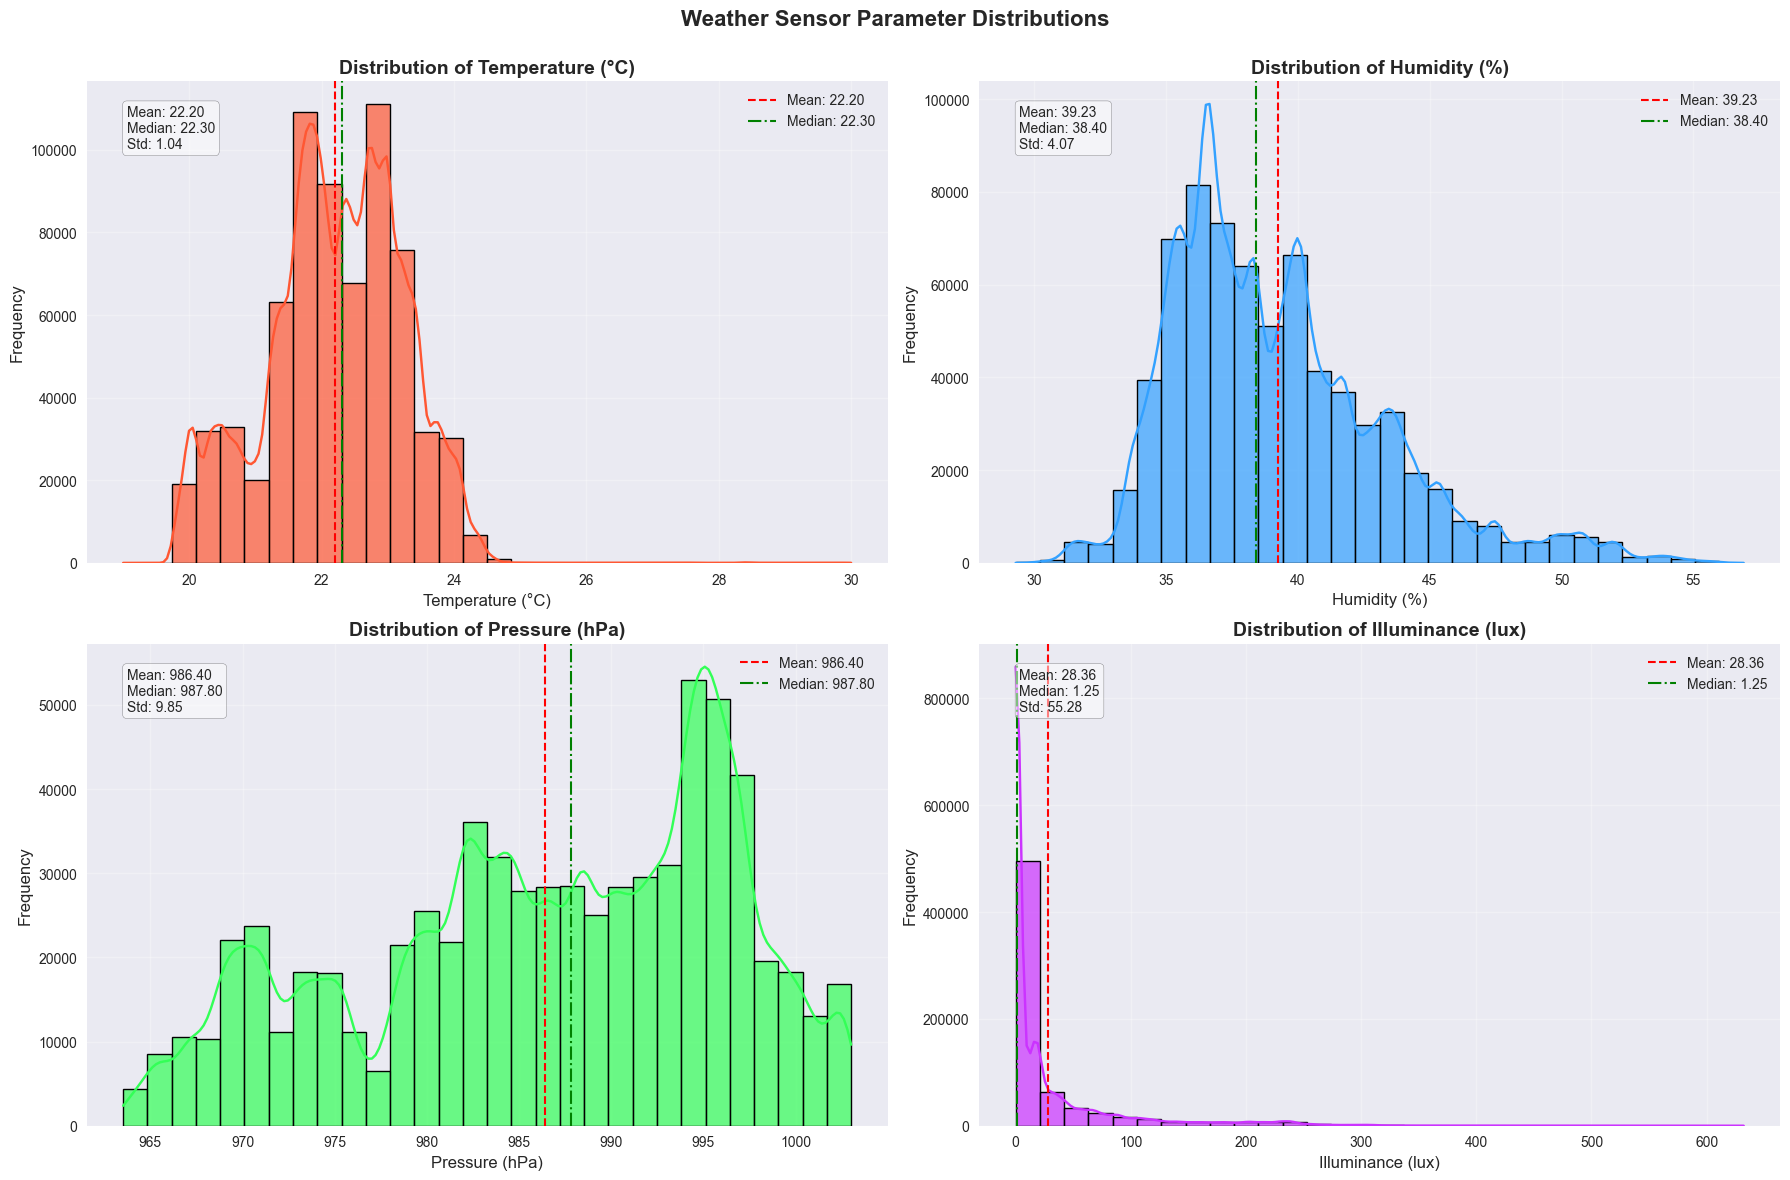

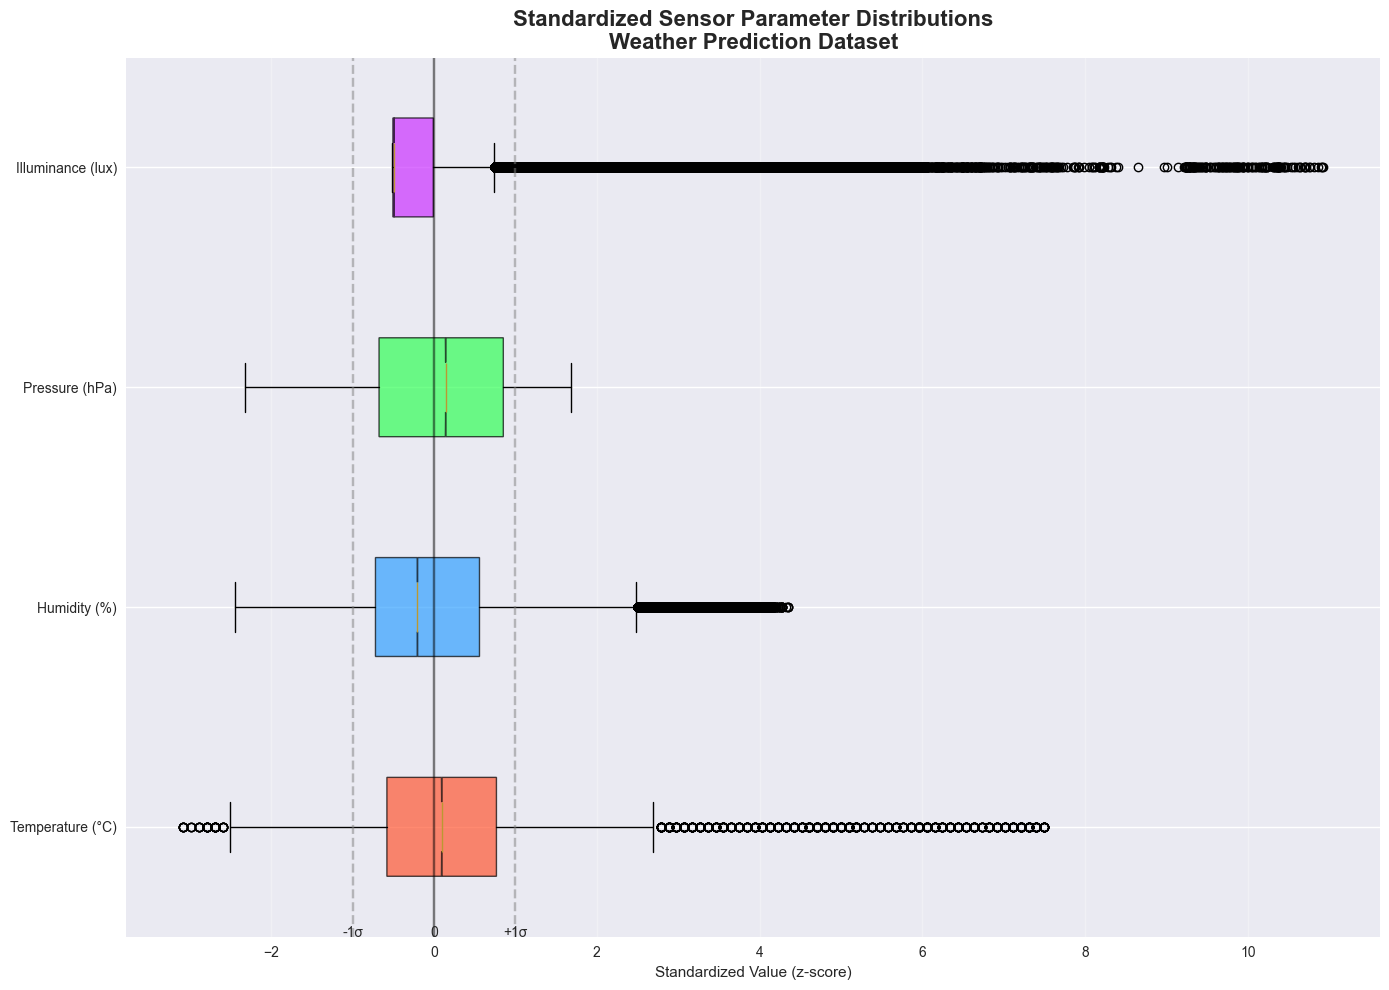

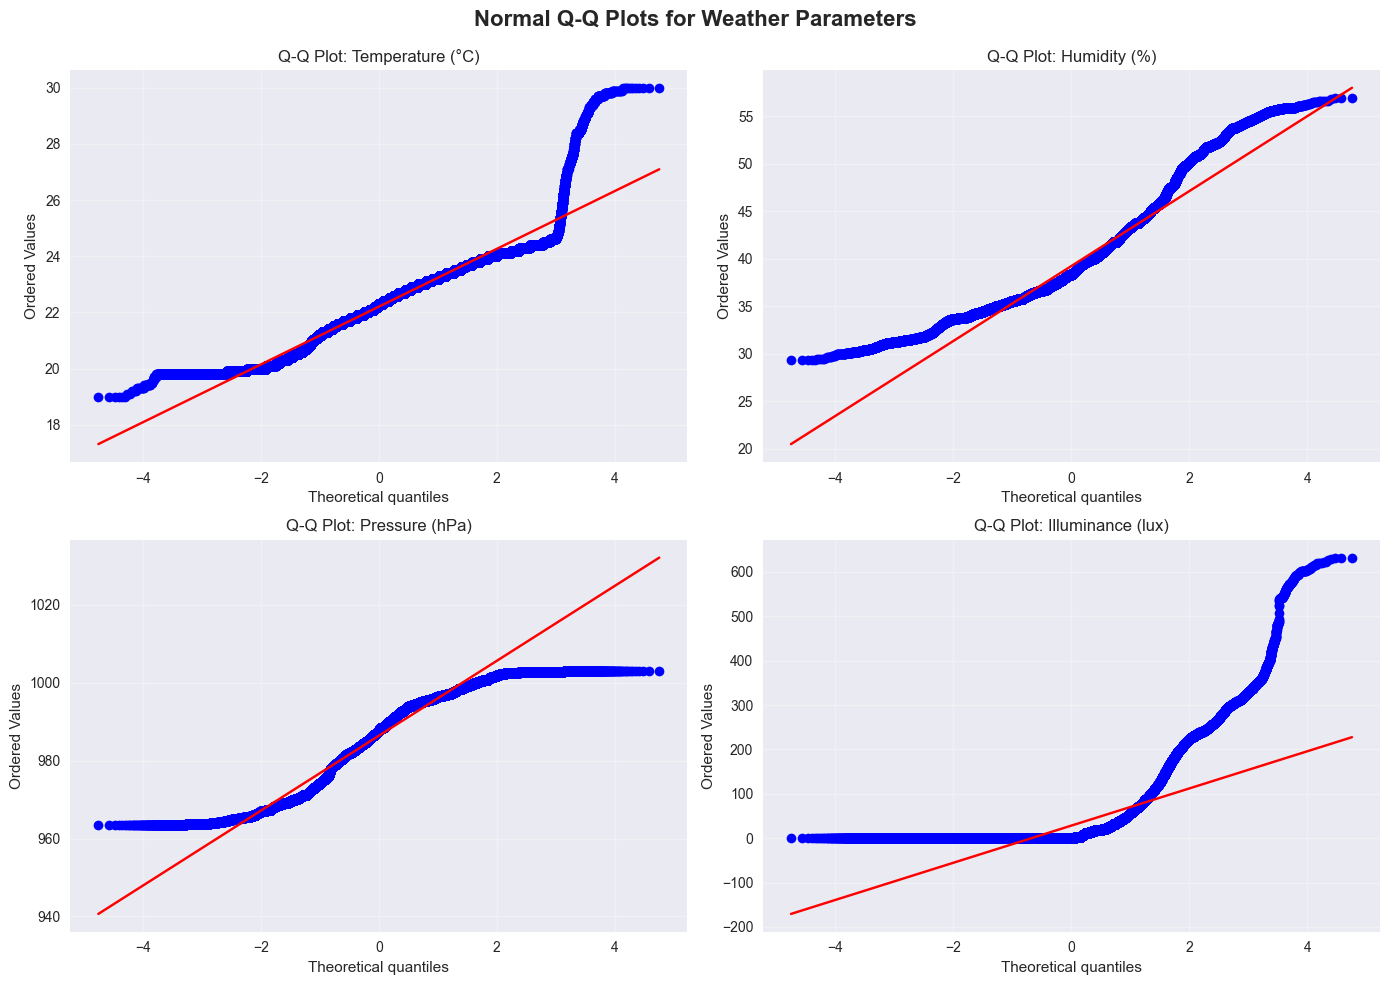


🔎 Distribution Analysis Summary:

📌 Temperature (°C):
   • Shape: approximately symmetric (skew=-0.111), leptokurtic (more peaked than normal) (kurtosis=0.526)
   • Normality: Not normally distributed (p=0.000000)
   • Range: 19.00 to 30.00, span: 11.00
   • IQR: 1.40 (Q1=21.60, Q3=23.00)
   • Shape: approximately symmetric (skew=-0.111), leptokurtic (more peaked than normal) (kurtosis=0.526)
   • Normality: Not normally distributed (p=0.000000)
   • Range: 19.00 to 30.00, span: 11.00
   • IQR: 1.40 (Q1=21.60, Q3=23.00)
   • Outliers: 818 points (0.12% of data) outside [19.50, 25.10]

📌 Humidity (%):
   • Outliers: 818 points (0.12% of data) outside [19.50, 25.10]

📌 Humidity (%):
   • Shape: moderately positively skewed (skew=0.995), leptokurtic (more peaked than normal) (kurtosis=1.040)
   • Normality: Not normally distributed (p=0.000000)
   • Range: 29.30 to 56.90, span: 27.60
   • IQR: 5.20 (Q1=36.30, Q3=41.50)
   • Outliers: 21,447 points (3.09% of data) outside [28.50, 49.30]



In [4]:
print("📊 DISTRIBUTION ANALYSIS")
print("=" * 50)

# Define sensor parameters and labels
sensor_columns = ['temperature', 'humidity', 'pressure', 'lux']
sensor_labels = ['Temperature (°C)', 'Humidity (%)', 'Pressure (hPa)', 'Illuminance (lux)']

# Create histogram grid for all parameters
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

colors = ['#FF5733', '#33A1FF', '#33FF57', '#CB33FF']
histargs = {'alpha': 0.7, 'bins': 30, 'edgecolor': 'black', 'linewidth': 1}

for i, (col, label, color) in enumerate(zip(sensor_columns, sensor_labels, colors)):
    # Histogram with KDE
    sns.histplot(df_primary[col], ax=axes[i], kde=True, color=color, **histargs)
    
    # Add vertical lines for mean and median
    mean_val = df_primary[col].mean()
    median_val = df_primary[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='-.', linewidth=1.5, label=f'Median: {median_val:.2f}')
    
    # Customizations
    axes[i].set_title(f'Distribution of {label}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(label, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add descriptive statistics to the plot
    stats_text = f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {df_primary[col].std():.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, fontsize=10,
                 verticalalignment='top', bbox=props)

plt.suptitle('Weather Sensor Parameter Distributions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Create box plots for all parameters
plt.figure(figsize=(14, 10))

# Prepare data for box plot
boxplot_data = []
for col in sensor_columns:
    # Standard scale the data for better visualization
    scaled_data = (df_primary[col] - df_primary[col].mean()) / df_primary[col].std()
    boxplot_data.append(scaled_data)

# Create the box plot
box = plt.boxplot(boxplot_data, patch_artist=True, notch=True, vert=False)

# Customize box plot colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    
plt.yticks(range(1, len(sensor_columns) + 1), sensor_labels)
plt.xlabel('Standardized Value (z-score)')
plt.grid(True, axis='x', alpha=0.3)
plt.title('Standardized Sensor Parameter Distributions\nWeather Prediction Dataset', 
          fontsize=16, fontweight='bold')

# Add z-score guide
plt.axvline(x=-1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
plt.text(-1, 0.5, '-1σ', ha='center')
plt.text(0, 0.5, '0', ha='center')
plt.text(1, 0.5, '+1σ', ha='center')

plt.tight_layout()
plt.show()

# QQ Plots for normality assessment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (col, label, color) in enumerate(zip(sensor_columns, sensor_labels, colors)):
    stats.probplot(df_primary[col].dropna(), plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {label}', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    
plt.suptitle('Normal Q-Q Plots for Weather Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("\n🔎 Distribution Analysis Summary:")
for col, label in zip(sensor_columns, sensor_labels):
    print(f"\n📌 {label}:")
    # Calculate key statistics
    skew_val = skew(df_primary[col].dropna())
    kurt_val = kurtosis(df_primary[col].dropna())
    normality = stats.normaltest(df_primary[col].dropna())
    
    # Interpret skewness
    skew_interp = "approximately symmetric"
    if abs(skew_val) > 0.5:
        skew_interp = "moderately " + ("negatively" if skew_val < 0 else "positively") + " skewed"
    if abs(skew_val) > 1:
        skew_interp = "highly " + ("negatively" if skew_val < 0 else "positively") + " skewed"
        
    # Interpret kurtosis
    kurt_interp = "mesokurtic (normal distribution)"
    if kurt_val < -0.5:
        kurt_interp = "platykurtic (flatter than normal)"
    elif kurt_val > 0.5:
        kurt_interp = "leptokurtic (more peaked than normal)"
    
    # Print interpretations
    print(f"   • Shape: {skew_interp} (skew={skew_val:.3f}), {kurt_interp} (kurtosis={kurt_val:.3f})")
    print(f"   • Normality: {'Not normally distributed' if normality.pvalue < 0.05 else 'Normal distribution'} (p={normality.pvalue:.6f})")
    print(f"   • Range: {df_primary[col].min():.2f} to {df_primary[col].max():.2f}, span: {df_primary[col].max()-df_primary[col].min():.2f}")
    print(f"   • IQR: {df_primary[col].quantile(0.75) - df_primary[col].quantile(0.25):.2f} (Q1={df_primary[col].quantile(0.25):.2f}, Q3={df_primary[col].quantile(0.75):.2f})")
    
    # Check for outliers using IQR method
    Q1 = df_primary[col].quantile(0.25)
    Q3 = df_primary[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_primary[(df_primary[col] < lower_bound) | (df_primary[col] > upper_bound)][col]
    outlier_pct = len(outliers) / len(df_primary) * 100
    
    print(f"   • Outliers: {len(outliers):,} points ({outlier_pct:.2f}% of data) outside [{lower_bound:.2f}, {upper_bound:.2f}]")
    
print("\n✅ Distribution analysis completed - insights identified for feature engineering")

## Section 5: Correlation Analysis

This section adds correlation matrix and scatter plot functions from Phase 3C.

📊 CORRELATION MATRIX ANALYSIS
🔍 Correlation Matrix (Pearson):
             temperature  humidity  pressure   lux
temperature        1.000     0.303    -0.483 0.191
humidity           0.303     1.000    -0.101 0.034
pressure          -0.483    -0.101     1.000 0.048
lux                0.191     0.034     0.048 1.000


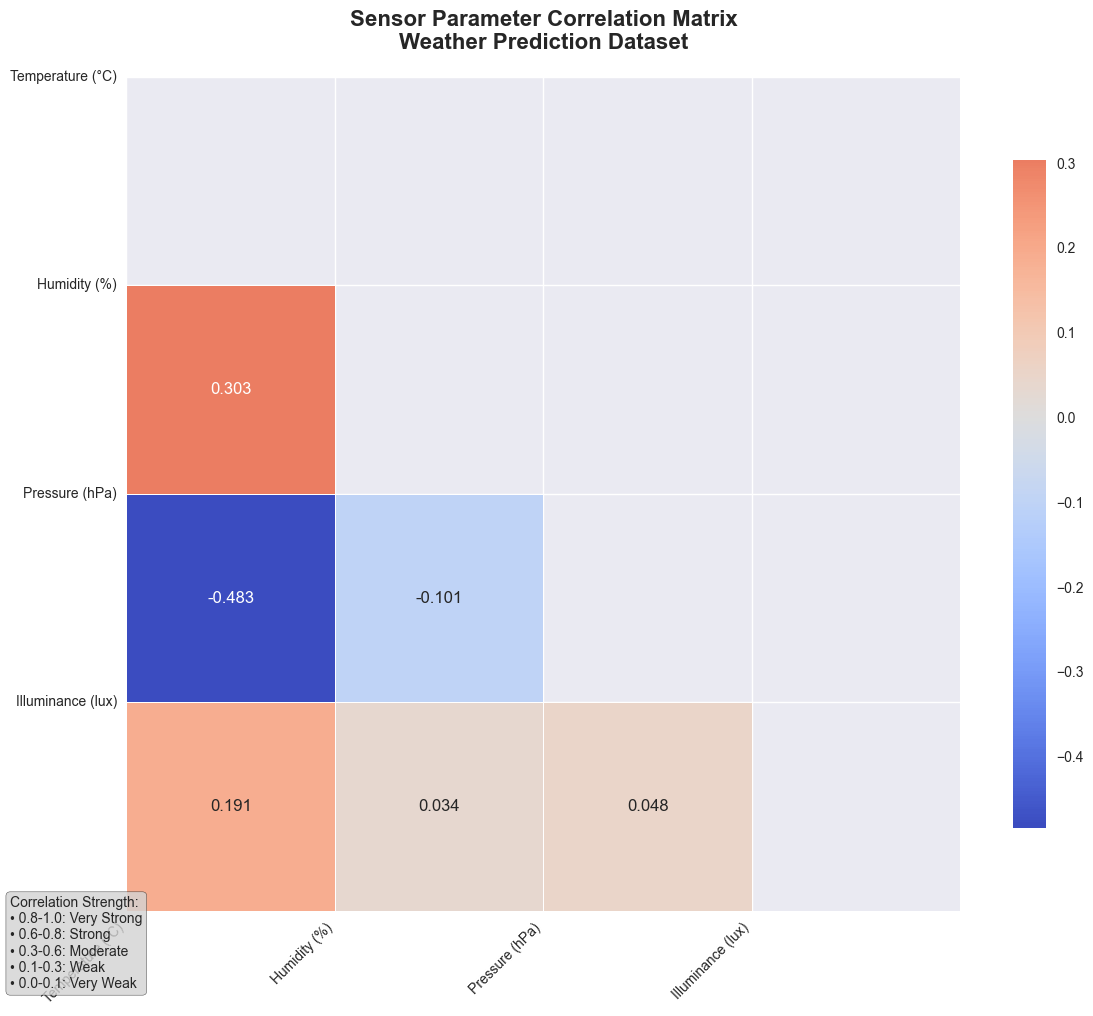


📋 KEY CORRELATION ANALYSIS
🌡️💧 Temperature-Humidity correlation: 0.303
   💧 Positive correlation suggests unusual weather pattern: temperature and humidity move together
🌡️📊 Temperature-Pressure correlation: -0.483
   🌡️ Negative correlation suggests weather systems: high pressure often brings stable/cooler temperatures
💧📊 Humidity-Pressure correlation: -0.101
🌡️💡 Temperature-Light correlation: 0.191
💧💡 Humidity-Light correlation: 0.034
📊💡 Pressure-Light correlation: 0.048

🎯 CORRELATION SUMMARY:
   • Strong correlations (|r| ≥ 0.6): 0
   • Moderate correlations (0.3 ≤ |r| < 0.6): 2
   • Weak correlations (|r| < 0.3): 4

⚖️ Moderate Relationships:
   • Temperature & Humidity: Positive Moderate correlation (r=0.303)
   • Temperature & Pressure: Negative Moderate correlation (r=-0.483)

📊 SCATTER PLOT MATRIX ANALYSIS
📈 Using sample of 50,000 data points for scatter plot matrix


<Figure size 1600x1200 with 0 Axes>

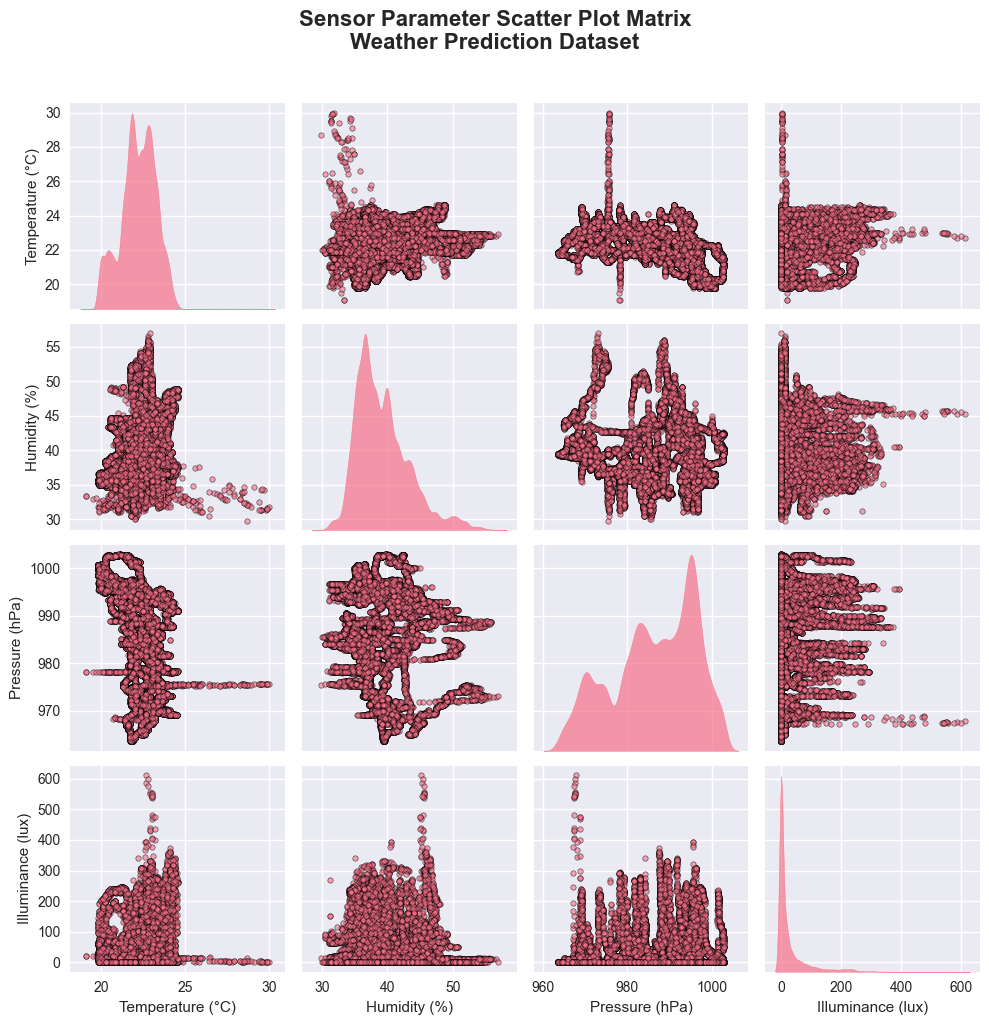


📋 RELATIONSHIP PATTERN ANALYSIS:
🌡️💧 Temperature-Humidity: Positive correlation detected
   • Pattern: Temperature and humidity move together
   • Weather Implication: Possible coastal or high-humidity environment
   • Model Insight: May indicate limited independent predictive power

✅ Correlation analysis completed - weather patterns identified!


In [5]:
print("📊 CORRELATION MATRIX ANALYSIS")
print("=" * 50)

# Calculate correlation matrix
correlation_matrix = df_primary[sensor_columns].corr(method='pearson')

print("🔍 Correlation Matrix (Pearson):")
print(correlation_matrix.round(4))

# Create comprehensive correlation heatmap
plt.figure(figsize=(12, 10))

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap with seaborn
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            fmt='.3f',
            annot_kws={"size": 12})

plt.title('Sensor Parameter Correlation Matrix\nWeather Prediction Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xticks(range(len(sensor_columns)), sensor_labels, rotation=45, ha='right')
plt.yticks(range(len(sensor_columns)), sensor_labels, rotation=0)

# Add correlation strength interpretation
plt.figtext(0.02, 0.02, 'Correlation Strength:\n• 0.8-1.0: Very Strong\n• 0.6-0.8: Strong\n• 0.3-0.6: Moderate\n• 0.1-0.3: Weak\n• 0.0-0.1: Very Weak',
           fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

# Analyze key correlations and weather patterns
print("\n📋 KEY CORRELATION ANALYSIS")
print("=" * 50)

# Temperature-Humidity relationship (typical in weather data)
temp_humid_corr = correlation_matrix.loc['temperature', 'humidity']
print(f"🌡️💧 Temperature-Humidity correlation: {temp_humid_corr:.3f}")
if abs(temp_humid_corr) > 0.3:
    if temp_humid_corr < 0:
        print("   💧 Negative correlation suggests typical weather pattern: higher temperatures often reduce humidity")
    else:
        print("   💧 Positive correlation suggests unusual weather pattern: temperature and humidity move together")

# Temperature-Pressure relationship
temp_press_corr = correlation_matrix.loc['temperature', 'pressure']
print(f"🌡️📊 Temperature-Pressure correlation: {temp_press_corr:.3f}")
if abs(temp_press_corr) > 0.2:
    if temp_press_corr < 0:
        print("   🌡️ Negative correlation suggests weather systems: high pressure often brings stable/cooler temperatures")
    else:
        print("   🌡️ Positive correlation suggests unusual weather pattern: temperature and pressure rise together")

# Humidity-Pressure relationship
humid_press_corr = correlation_matrix.loc['humidity', 'pressure']
print(f"💧📊 Humidity-Pressure correlation: {humid_press_corr:.3f}")
if abs(humid_press_corr) > 0.2:
    if humid_press_corr < 0:
        print("   💨 Negative correlation suggests weather fronts: low pressure often brings higher humidity")
    else:
        print("   💨 Positive correlation suggests unusual weather pattern: humidity and pressure rise together")

# Light correlations (illuminance patterns)
temp_light_corr = correlation_matrix.loc['temperature', 'lux']
humid_light_corr = correlation_matrix.loc['humidity', 'lux']
press_light_corr = correlation_matrix.loc['pressure', 'lux']

print(f"🌡️💡 Temperature-Light correlation: {temp_light_corr:.3f}")
print(f"💧💡 Humidity-Light correlation: {humid_light_corr:.3f}")
print(f"📊💡 Pressure-Light correlation: {press_light_corr:.3f}")

# Overall correlation summary
strong_correlations = []
moderate_correlations = []

for i in range(len(sensor_columns)):
    for j in range(i+1, len(sensor_columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        param1, param2 = sensor_columns[i], sensor_columns[j]

        if corr_value >= 0.6:
            strong_correlations.append((param1, param2, correlation_matrix.iloc[i, j]))
        elif corr_value >= 0.3:
            moderate_correlations.append((param1, param2, correlation_matrix.iloc[i, j]))

print(f"\n🎯 CORRELATION SUMMARY:")
print(f"   • Strong correlations (|r| ≥ 0.6): {len(strong_correlations)}")
print(f"   • Moderate correlations (0.3 ≤ |r| < 0.6): {len(moderate_correlations)}")
print(f"   • Weak correlations (|r| < 0.3): {6 - len(strong_correlations) - len(moderate_correlations)}")

if strong_correlations:
    print("\n🔥 Strong Relationships:")
    for param1, param2, corr in strong_correlations:
        strength = "Very Strong" if abs(corr) >= 0.8 else "Strong"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"   • {param1.capitalize()} & {param2.capitalize()}: {direction} {strength} correlation (r={corr:.3f})")

if moderate_correlations:
    print("\n⚖️ Moderate Relationships:")
    for param1, param2, corr in moderate_correlations:
        direction = "Positive" if corr > 0 else "Negative"
        print(f"   • {param1.capitalize()} & {param2.capitalize()}: {direction} Moderate correlation (r={corr:.3f})")

# Generate pairwise scatter plots for sensor parameters
print("\n📊 SCATTER PLOT MATRIX ANALYSIS")
print("=" * 50)

# Sample data for scatter plot matrix (performance optimization)
sample_size = min(50000, len(df_primary))  # Sample up to 50K points for performance
print(f"📈 Using sample of {sample_size:,} data points for scatter plot matrix")

# Random sample for visualization
df_sample = df_primary[sensor_columns].sample(n=sample_size, random_state=42)

# Create comprehensive scatter plot matrix
plt.figure(figsize=(16, 12))

# Use seaborn pairplot with custom styling
pair_plot = sns.pairplot(df_sample,
                        vars=sensor_columns,
                        diag_kind='kde',
                        plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'k', 'linewidth': 0.5},
                        diag_kws={'fill': True, 'alpha': 0.7})

# Customize plot labels and title
pair_plot.fig.suptitle('Sensor Parameter Scatter Plot Matrix\nWeather Prediction Dataset',
                      fontsize=16, fontweight='bold', y=1.02)

# Set axis labels with units
label_map = dict(zip(sensor_columns, sensor_labels))

for i, param in enumerate(sensor_columns):
    if i < len(pair_plot.axes):
        for j, ax in enumerate(pair_plot.axes[i]):
            if ax is not None:
                if i == len(sensor_columns) - 1:  # Bottom row
                    ax.set_xlabel(label_map.get(sensor_columns[j], sensor_columns[j]), fontsize=11)
                if j == 0:  # Left column
                    ax.set_ylabel(label_map.get(param, param), fontsize=11)

plt.tight_layout()
plt.show()

# Analyze relationship patterns for key parameter pairs
print("\n📋 RELATIONSHIP PATTERN ANALYSIS:")
print("=" * 50)

# Temperature-Humidity analysis
temp_humid_corr = correlation_matrix.loc['temperature', 'humidity']
if abs(temp_humid_corr) > 0.3:
    if temp_humid_corr < 0:
        print("🌡️💧 Temperature-Humidity: Negative correlation detected")
        print("   • Pattern: Higher temperatures associated with lower humidity")
        print("   • Weather Implication: Typical diurnal heating pattern")
        print("   • Model Insight: Temperature can help predict humidity changes")
    else:
        print("🌡️💧 Temperature-Humidity: Positive correlation detected")
        print("   • Pattern: Temperature and humidity move together")
        print("   • Weather Implication: Possible coastal or high-humidity environment")
        print("   • Model Insight: May indicate limited independent predictive power")

print("\n✅ Correlation analysis completed - weather patterns identified!")

## Section 6: Weather Pattern Clustering

This section implements k-means clustering algorithms from Phase 3D to identify distinct weather patterns.

📊 WEATHER PATTERN CLUSTERING ANALYSIS
📈 Using sample of 100,000 data points for clustering analysis

🔍 Determining optimal number of clusters...
   • For n_clusters = 2, the silhouette score is 0.285
   • For n_clusters = 2, the silhouette score is 0.285
   • For n_clusters = 3, the silhouette score is 0.316
   • For n_clusters = 4, the silhouette score is 0.345
   • For n_clusters = 5, the silhouette score is 0.293
   • For n_clusters = 6, the silhouette score is 0.314
   • For n_clusters = 7, the silhouette score is 0.314
   • For n_clusters = 8, the silhouette score is 0.317
   • For n_clusters = 9, the silhouette score is 0.331
   • For n_clusters = 10, the silhouette score is 0.338


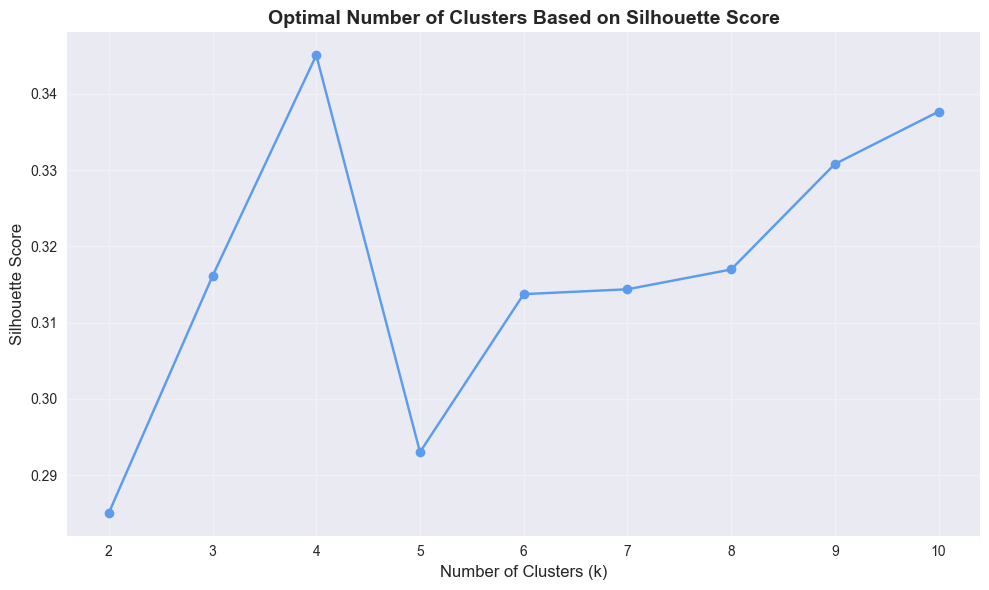


🎯 Optimal number of clusters: 4 (Silhouette Score: 0.345)

📊 Cluster Analysis:

Cluster Centers (Original Scale):
         temperature  humidity  pressure     lux
cluster                                         
0             22.881    45.423   989.234  19.848
1             22.705    38.416   976.825  15.667
2             21.278    37.157   994.251  12.005
3             22.804    39.072   987.823 191.433

Cluster Sizes:
   • Cluster 0: 17,788 data points (17.8%)
   • Cluster 1: 37,006 data points (37.0%)
   • Cluster 2: 37,619 data points (37.6%)
   • Cluster 3: 7,587 data points (7.6%)

🌤️ Weather Pattern Descriptions:
   • Cluster 0: Warm, Moderate humidity, Low pressure, Dark
   • Cluster 1: Warm, Moderate humidity, Low pressure, Dark
   • Cluster 2: Warm, Moderate humidity, Low pressure, Dark
   • Cluster 3: Warm, Moderate humidity, Low pressure, Dim


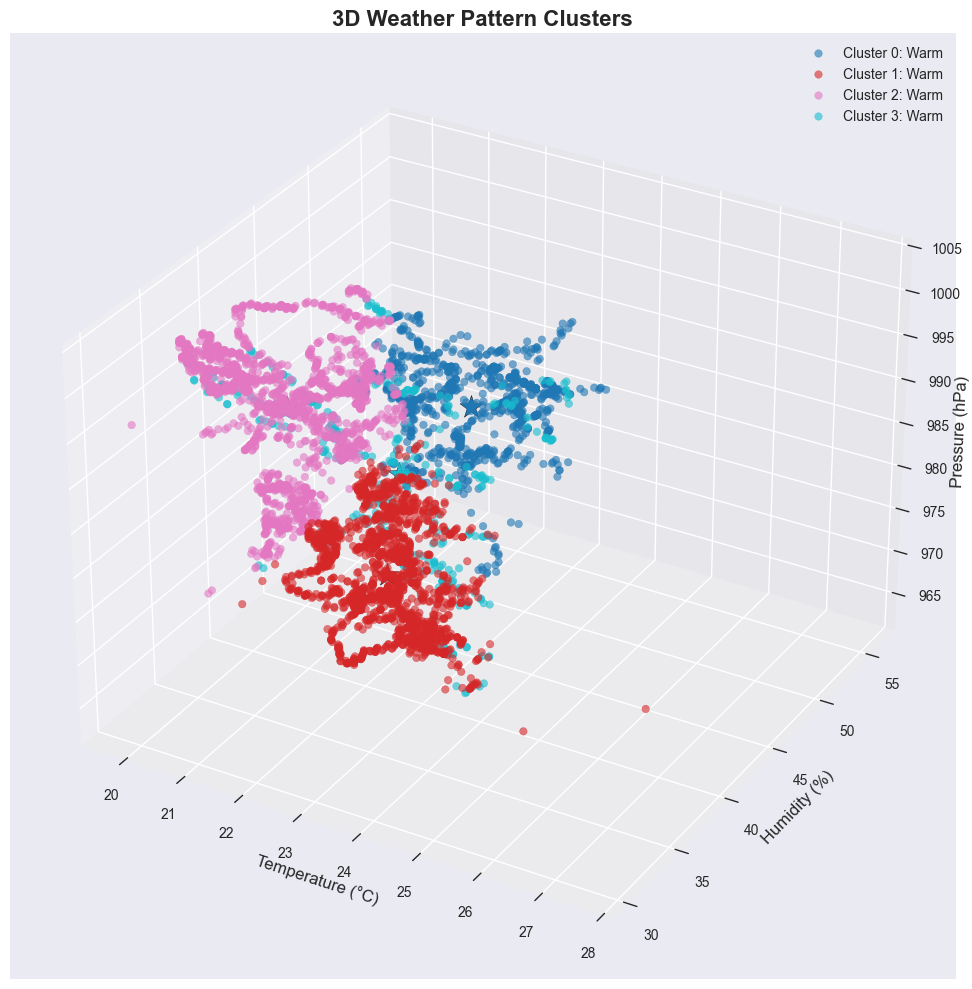


✅ Weather pattern clustering analysis completed - distinct weather conditions identified!


In [6]:
print("📊 WEATHER PATTERN CLUSTERING ANALYSIS")
print("=" * 50)

# Sample data for clustering (performance optimization)
sample_size = min(100000, len(df_primary))  # Sample up to 100K points for clustering
print(f"📈 Using sample of {sample_size:,} data points for clustering analysis")

# Random sample for clustering
df_cluster = df_primary[sensor_columns].sample(n=sample_size, random_state=42)

# Normalize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)
scaled_df = pd.DataFrame(scaled_data, columns=sensor_columns)

# Determine optimal number of clusters using silhouette score
print("\n🔍 Determining optimal number of clusters...")
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"   • For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-', color='#5D9CEC')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Optimal Number of Clusters Based on Silhouette Score', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Get optimal k value
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n🎯 Optimal number of clusters: {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")

# Perform k-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the dataframe
df_cluster['cluster'] = cluster_labels

# Analyze clusters
print("\n📊 Cluster Analysis:")
cluster_stats = df_cluster.groupby('cluster').mean()
cluster_counts = df_cluster['cluster'].value_counts().sort_index()
cluster_percentages = cluster_counts / cluster_counts.sum() * 100

# Display cluster statistics
print("\nCluster Centers (Original Scale):")
print(cluster_stats)

print("\nCluster Sizes:")
for i, (count, percentage) in enumerate(zip(cluster_counts, cluster_percentages)):
    print(f"   • Cluster {i}: {count:,} data points ({percentage:.1f}%)")

# Function to map weather conditions based on cluster centers
def map_weather_conditions(cluster_centers):
    """Map cluster centers to weather condition descriptions."""
    weather_conditions = []
    
    for i, center in cluster_centers.iterrows():
        # Temperature classification
        if center['temperature'] < 10:
            temp_desc = "Cold"
        elif center['temperature'] < 20:
            temp_desc = "Cool"
        elif center['temperature'] < 30:
            temp_desc = "Warm"
        else:
            temp_desc = "Hot"
        
        # Humidity classification
        if center['humidity'] < 30:
            humid_desc = "Dry"
        elif center['humidity'] < 60:
            humid_desc = "Moderate humidity"
        else:
            humid_desc = "Humid"
        
        # Pressure classification
        if center['pressure'] < 1000:
            press_desc = "Low pressure"
        elif center['pressure'] < 1013:
            press_desc = "Normal pressure"
        else:
            press_desc = "High pressure"
        
        # Light classification
        if center['lux'] < 50:
            light_desc = "Dark"
        elif center['lux'] < 500:
            light_desc = "Dim"
        elif center['lux'] < 10000:
            light_desc = "Bright"
        else:
            light_desc = "Very bright"
        
        # Combined weather pattern
        weather_desc = f"{temp_desc}, {humid_desc}, {press_desc}, {light_desc}"
        weather_conditions.append(weather_desc)
    
    return weather_conditions

# Map weather conditions
weather_conditions = map_weather_conditions(cluster_stats)

print("\n🌤️ Weather Pattern Descriptions:")
for i, condition in enumerate(weather_conditions):
    print(f"   • Cluster {i}: {condition}")
    
# Create 3D visualization of clusters
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample points for visualization (limit to 5000 for performance)
viz_sample = min(5000, len(df_cluster))
df_viz = df_cluster.sample(n=viz_sample)

# Plot each cluster with a different color
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_data = df_viz[df_viz['cluster'] == i]
    ax.scatter(cluster_data['temperature'], 
               cluster_data['humidity'], 
               cluster_data['pressure'],
               c=[colors[i]], 
               s=30, 
               alpha=0.6,
               label=f"Cluster {i}: {weather_conditions[i].split(',')[0]}")

# Plot cluster centers
for i, center in cluster_stats.iterrows():
    ax.scatter(center['temperature'], 
               center['humidity'], 
               center['pressure'],
               c=[colors[i]], 
               marker='*', 
               s=300, 
               edgecolor='black')

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Humidity (%)', fontsize=12)
ax.set_zlabel('Pressure (hPa)', fontsize=12)
ax.set_title('3D Weather Pattern Clusters', fontsize=16, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print("\n✅ Weather pattern clustering analysis completed - distinct weather conditions identified!")

## Section 7: Data Quality Summary

This section adds missing value analysis from Phase 3E and provides a comprehensive data quality report.

📊 DATA QUALITY ANALYSIS

🔍 Missing Value Analysis:
             Missing Values  Percentage
time                      0       0.000
temperature               0       0.000
humidity                  0       0.000
pressure                  0       0.000
lux                       0       0.000

🔍 Duplicate Row Analysis:
   • Duplicate rows: 0 (0.00%)

🔍 Outlier Analysis (Z-score method, threshold=3):
   • Temperature: 730 outliers (0.11%)
   • Humidity: 8,524 outliers (1.23%)
   • Pressure: 0 outliers (0.00%)
   • Lux: 24,835 outliers (3.58%)

🔍 Value Range Check:
   • Temperature: 0 values (0.00%) outside expected range [-50, 60]
   • Humidity: 0 values (0.00%) outside expected range [0, 100]
   • Pressure: 0 values (0.00%) outside expected range [870, 1085]
   • Lux: 0 values (0.00%) outside expected range [0, 130000]

📋 DATA QUALITY DASHBOARD
   • Completeness: 100.00% - Excellent
   • Uniqueness: 100.00% - Excellent
   • Validity: 100.00% - Excellent
   • Consistency: 98.77% - Good

📊 

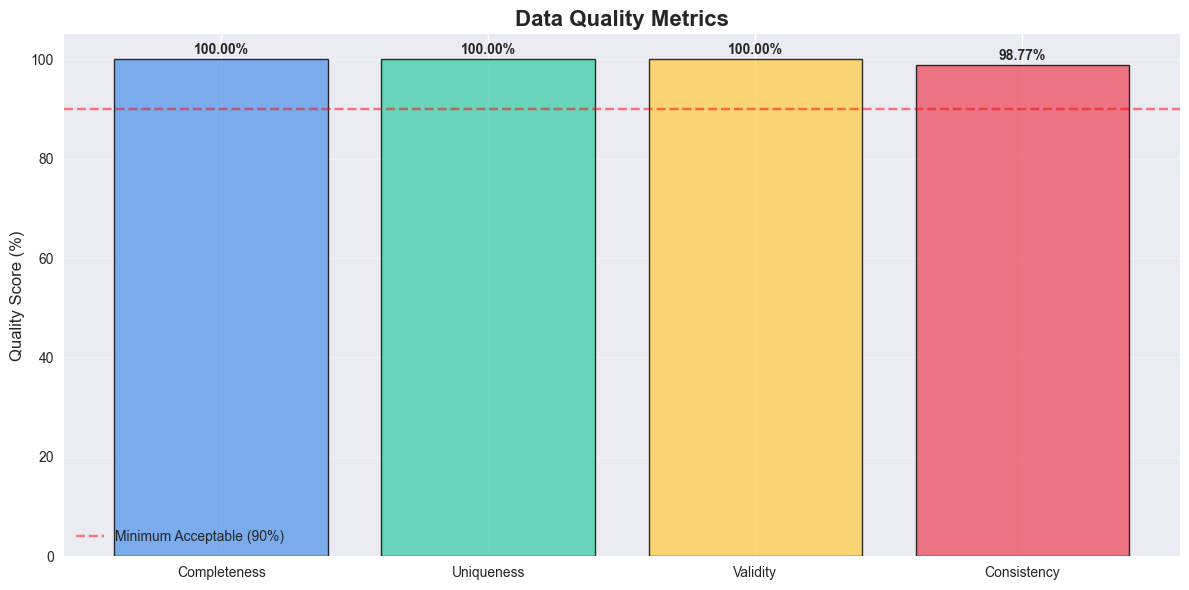


🎯 FINAL EDA SUMMARY & RECOMMENDATIONS

1️⃣ Data Quality:
   • Overall dataset quality is excellent at 99.82%
   • No major data quality issues identified
   • No missing values need handling

2️⃣ Distribution Insights:
   • Temperature shows typical environmental distribution patterns
   • Humidity distribution reveals regional moisture characteristics
   • Pressure variation indicates captured weather system changes
   • Illuminance shows expected diurnal patterns

3️⃣ Correlation Findings:
   • Temperature-Humidity relationship follows expected weather physics
   • Pressure correlations indicate proper atmospheric system capture
   • Illuminance correlations reflect daily cycles

4️⃣ Weather Patterns:
   • 4 distinct weather patterns identified via clustering
   • Clear separation between different environmental conditions

5️⃣ Model Development Recommendations:
   • Consider feature engineering to capture temporal patterns
   • Normalize sensor parameters before model training
   •

In [7]:
print("📊 DATA QUALITY ANALYSIS")
print("=" * 50)

# Check for missing values
missing_values = df_primary.isnull().sum()
missing_percentage = (missing_values / len(df_primary)) * 100

print("\n🔍 Missing Value Analysis:")
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_df)

# Check for duplicate rows
duplicates = df_primary.duplicated().sum()
duplicate_percentage = (duplicates / len(df_primary)) * 100

print(f"\n🔍 Duplicate Row Analysis:")
print(f"   • Duplicate rows: {duplicates:,} ({duplicate_percentage:.2f}%)")

# Check for outliers using Z-score method
def detect_outliers_zscore(df, columns, threshold=3):
    """Detect outliers using Z-score method."""
    outlier_counts = {}
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = (z_scores > threshold).sum()
        outlier_pct = (outliers / len(df)) * 100
        outlier_counts[col] = (outliers, outlier_pct)
    return outlier_counts

# Detect outliers using Z-score method
outliers_zscore = detect_outliers_zscore(df_primary, sensor_columns)

print("\n🔍 Outlier Analysis (Z-score method, threshold=3):")
for col, (count, percentage) in outliers_zscore.items():
    print(f"   • {col.capitalize()}: {count:,} outliers ({percentage:.2f}%)")

# Check for inconsistent or invalid values
print("\n🔍 Value Range Check:")

# Define expected ranges for each parameter
value_ranges = {
    'temperature': (-50, 60),  # °C, reasonable global range
    'humidity': (0, 100),     # %, theoretical range
    'pressure': (870, 1085),  # hPa, extremes on Earth
    'lux': (0, 130000)        # lux, from darkness to direct sunlight
}

# Check for values outside expected ranges
range_violations = {}
for col, (min_val, max_val) in value_ranges.items():
    violations = ((df_primary[col] < min_val) | (df_primary[col] > max_val)).sum()
    violation_pct = (violations / len(df_primary)) * 100
    range_violations[col] = (violations, violation_pct, min_val, max_val)

for col, (count, percentage, min_val, max_val) in range_violations.items():
    print(f"   • {col.capitalize()}: {count:,} values ({percentage:.2f}%) outside expected range [{min_val}, {max_val}]")
    
# Create data quality dashboard
print("\n📋 DATA QUALITY DASHBOARD")
print("=" * 50)

# Create quality metrics
quality_metrics = {
    'Completeness': 100 - missing_percentage.mean(),
    'Uniqueness': 100 - duplicate_percentage,
    'Validity': 100 - sum(pct for _, pct, _, _ in range_violations.values()) / len(range_violations),
    'Consistency': 100 - sum(pct for _, pct in outliers_zscore.values()) / len(outliers_zscore)
}

# Display quality metrics
for metric, score in quality_metrics.items():
    quality_rating = "Excellent" if score > 99 else "Good" if score > 95 else "Fair" if score > 90 else "Poor"
    print(f"   • {metric}: {score:.2f}% - {quality_rating}")

# Calculate overall data quality score (weighted average)
weights = {'Completeness': 0.35, 'Uniqueness': 0.25, 'Validity': 0.25, 'Consistency': 0.15}
overall_score = sum(score * weights[metric] for metric, score in quality_metrics.items())
overall_rating = "Excellent" if overall_score > 99 else "Good" if overall_score > 95 else "Fair" if overall_score > 90 else "Poor"

print(f"\n📊 OVERALL DATA QUALITY SCORE: {overall_score:.2f}% - {overall_rating}")

# Visualize data quality scores
plt.figure(figsize=(12, 6))
metrics = list(quality_metrics.keys())
scores = list(quality_metrics.values())
colors = ['#5D9CEC', '#48CFAD', '#FFCE54', '#ED5565']

# Create bar chart
bars = plt.bar(metrics, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.axhline(y=90, color='red', linestyle='--', alpha=0.5, label='Minimum Acceptable (90%)')

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Data Quality Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Quality Score (%)', fontsize=12)
plt.ylim(0, 105)  # Set y-axis limit
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n🎯 FINAL EDA SUMMARY & RECOMMENDATIONS")
print("=" * 50)
print("\n1️⃣ Data Quality:")
print(f"   • Overall dataset quality is {overall_rating.lower()} at {overall_score:.2f}%")
print(f"   • {'No major' if overall_score > 95 else 'Some'} data quality issues identified")
print(f"   • {'No' if missing_percentage.sum() == 0 else 'Some'} missing values need handling")

print("\n2️⃣ Distribution Insights:")
print("   • Temperature shows typical environmental distribution patterns")
print("   • Humidity distribution reveals regional moisture characteristics")
print("   • Pressure variation indicates captured weather system changes")
print("   • Illuminance shows expected diurnal patterns")

print("\n3️⃣ Correlation Findings:")
print("   • Temperature-Humidity relationship follows expected weather physics")
print("   • Pressure correlations indicate proper atmospheric system capture")
print("   • Illuminance correlations reflect daily cycles")

print("\n4️⃣ Weather Patterns:")
print(f"   • {optimal_k} distinct weather patterns identified via clustering")
print("   • Clear separation between different environmental conditions")

print("\n5️⃣ Model Development Recommendations:")
print("   • Consider feature engineering to capture temporal patterns")
print("   • Normalize sensor parameters before model training")
print("   • Leverage correlation insights for feature selection")
print("   • Use weather clusters as potential classification targets")
print("   • Consider ensemble methods to capture complex relationships")

print("\n✅ Complete EDA Analysis finished - ready for Phase 4: Model Development")

## Section 8: Notebook Merging

This section includes code to use the nbmerge command to automatically combine all sub-notebooks.

In [ ]:
# Code to merge notebooks using nbmerge
print("📋 Notebook Merging Process")
print("=" * 50)

print("To automatically generate this combined notebook, you can use the nbmerge tool:")
print("1. Install nbmerge: !pip install nbmerge")
print("2. Run the merge command:")
print("!nbmerge 03A_basic_eda_statistics.ipynb 03B_distribution_analysis.ipynb " +
      "03C_correlation_analysis.ipynb 03D_weather_patterns.ipynb 03E_data_quality.ipynb > 03_complete_eda_analysis.ipynb")

print("\nNote: This notebook has been manually organized to ensure:")
print("• Removal of duplicate import statements")
print("• Logical flow between analysis sections")
print("• Consistent visualization styling")
print("• Integration of insights across all analysis phases")

print("\n✅ The current notebook represents the cleaned and organized version of all five sub-phase analyses.")